# Homework 3 - Master's Degrees from all over!

Group 25:

Petra Udovicic: <petra.udovicic1997@gmail.com>, [GitHub](https://github.com/petraudovicic)

Dila Aslan: <dilaaslan0144@gmail.com>, [GitHub](https://github.com/dilaaslan3)

Edo Fejzic: <edo.fejzic@hotmail.com>, [GitHub](https://github.com/do3-173)

## 1. Data collection

### 1.1. Get the list of master's degree courses

Firstly, we need to create the `list_of_masters.py` module. 

In [ ]:
# Libraries
import requests
from bs4 import BeautifulSoup
import time
import os
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

In [ ]:
BASE_URL = "https://www.findamasters.com/masters-degrees/msc-degrees/"
OUTPUT_FILE = "masters_urls.txt"

Checking out the URL and inspecting the website we find out the next piece of HTML code: `<a class="courseLink text-dark" href="/masters-degrees/course/applied-economics-banking-and-financial-markets-online-msc/?i280d8352c56675" title="Applied Economics (Banking and Financial Markets), online MSc at University of Bath Online, University of Bath"><u>Applied Economics (Banking and Financial Markets), online MSc</u></a>`. The class `courseLink text-dark` will be helpful for us in getting all the course links. 

In [ ]:
def get_course_urls(page_url):
    while True:
        try:
            response = requests.get(page_url, timeout=5)
            response.raise_for_status()
            break
        except requests.RequestException as e:
            # In case of failing request
            print(f"Request failed: {e}")
            time.sleep(1)
    soup = BeautifulSoup(response.content, "html.parser")
    course_links = soup.find_all("a", class_="courseLink text-dark")
    urls = [
        "https://www.findamasters.com" + link["href"]
        for link in course_links
        if "href" in link.attrs
    ]
    return urls

In [ ]:
for page in range(number_of_pages):
    # Progress bar
    if (page + 1) % 25 == 0 or page == 0:
        print(f"Scraping page {page + 1}")

    # String of page_url, in the first page only get the BASE_URL
    if page == 0:
        page_url = f"{BASE_URL}"
    else:
        page_url = f"{BASE_URL}?PG={page + 1}"
    urls = get_course_urls(page_url)

    if urls:
        # Append to the file so it remembers the previous entries
        with open(OUTPUT_FILE, "a") as file:
            for url in urls:
                file.write(f"{url}\n")

    # Sleeping to not have too many requests
    time.sleep(1)

After running the script, we need to check out the file, it should contain 6000 URLS.

In [ ]:
with open(OUTPUT_FILE, "r") as file:
    for count, line in enumerate(file):
        pass
# This needs to be 6000
print("Total Lines", count + 1)

Total Lines 6000


### 1.2. Crawl master's degree pages

For the second step, we need to download those HTML files and store them in the seperate folder. This will be done in the `crawler_master_html.py` module, below is the implementation.

In [ ]:
def download_html(url_and_folder):
    url, folder = url_and_folder
    while True:
        response = requests.get(url, timeout=5)
        # "Just a moment..." started showing up in some cases.
        # Until we get the content we want continue trying the same URL
        if "Just a moment..." in response.text:
            time.sleep(1)
        else:
            filename = url.split("/")[-2] + url.split("/")[-1] + ".html"
            path = os.path.join(folder, filename)
            with open(path, "w") as file:
                file.write(response.text)
            time.sleep(1)
            break

After writing the `download_html` function, now we need to use it on all of the URLS that are present in masters_urls.txt file.

In [ ]:
with open("masters_urls.txt", "r") as file:
    urls = [url.strip() for url in file.readlines()]

url_and_folder_pairs = []
for i, url in enumerate(urls):
    page_number = i // 15 + 1
    folder = f"HTML/Page_{page_number}"
    os.makedirs(folder, exist_ok=True)
    url_and_folder_pairs.append((url, folder))

# Asynchronous execution of download_html at most 10 threads to save time
with ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(download_html, url_and_folder_pairs)

Each of these HTML's will be downloaded in their respectful folder from where they came from. Asynchronous parallelism is being used for the function `download_html` to speed up the proces of crawling all the HTML's. 

### 1.3 Parse downloaded pages

For the final part, we need to parse downloaded HTML files. This will be done with the module `parser_html.py`. For all of the values of interest, we used Inspect Element in Firefox browser, to navigate to the correct HTML class that we need for data mining.

In [ ]:
def parse_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    course_name = (
        soup.find("h1", class_="course-header__course-title").text.strip()
        if soup.find("h1", class_="course-header__course-title")
        else ""
    )
    university_name = (
        soup.find("a", class_="course-header__institution").text.strip()
        if soup.find("a", class_="course-header__institution")
        else ""
    )
    faculty_name = (
        soup.find("a", class_="course-header__department").text.strip()
        if soup.find("a", class_="course-header__department")
        else ""
    )
    is_full_time = (
        soup.find("a", title="View all Full time Masters courses").text.strip()
        if soup.find("a", title="View all Full time Masters courses")
        else ""
    )
    description = (
        soup.find("div", id="Snippet").text.strip()
        if soup.find("div", id="Snippet")
        else ""
    )
    start_date = (
        soup.find("span", class_="key-info__start-date").text.strip()
        if soup.find("span", class_="key-info__start-date")
        else ""
    )
    fees = (
        soup.find("div", class_="course-sections__fees")
        .find("p")
        .get_text(separator=" ")
        .strip()
        if soup.find("div", class_="course-sections__fees")
        else ""
    )
    modality = (
        soup.find("span", class_="key-info__qualification").text.strip()
        if soup.find("span", class_="key-info__qualification")
        else ""
    )
    duration = (
        soup.find("span", class_="key-info__duration").text.strip()
        if soup.find("span", class_="key-info__duration")
        else ""
    )
    city = (
        soup.find("a", class_="course-data__city").text.strip()
        if soup.find("a", class_="course-data__city")
        else ""
    )
    country = (
        soup.find("a", class_="course-data__country").text.strip()
        if soup.find("a", class_="course-data__country")
        else ""
    )
    administration = (
        soup.find("a", class_="course-data__on-campus").text.strip()
        if soup.find("a", class_="course-data__on-campus")
        else ""
    )
    url = (
        soup.select_one('link[rel="canonical"]')["href"]
        if soup.select_one('link[rel="canonical"]')
        else ""
    )

    course_info = {
        "courseName": course_name,
        "universityName": university_name,
        "facultyName": faculty_name,
        "isItFullTime": is_full_time,
        "description": description,
        "startDate": start_date,
        "fees": fees,
        "modality": modality,
        "duration": duration,
        "city": city,
        "country": country,
        "administration": administration,
        "url": url,
    }

    return course_info

In [ ]:
def write_to_tsv(course_info, filename):
    with open("TSV/" + filename, "w", encoding="utf-8") as f:
        # First row we write the column names
        column_names = "\t".join(course_info.keys())
        f.write(column_names + "\n")
        # Second row we write the values of columns
        column_values = "\t".join(str(value) for value in course_info.values())
        f.write(column_values + "\n")

After writing `parse_html` and `write_to_tsv`, now we need to write a script that will use it. We take all of the files inside `HTML` folder, parse them, and store them in seperate `.tsv` files that are named `course_{i}.tsv` where the `i` is the course number from 1 to 6000.

In [ ]:
root_path = "HTML/"

course_counter = 1
for root, dirs, files in os.walk(root_path):
    for file in files:
        if file.endswith(".html"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                # Reading HTML
                html_content = f.read()

                # Parsing HTML
                course_info = parse_html(html_content)

                # " was giving us troubles so we removed it
                for key, value in course_info.items():
                    course_info[key] = value.replace('"', "")

                # Writing to the .tsv file
                tsv_filename = f"course_{course_counter}.tsv"
                write_to_tsv(course_info, tsv_filename)

                course_counter += 1

Now we need to test the dataset, if we managed to complete the task successfully.

In [ ]:
# Read the TSV data
df = pd.read_csv("TSV/course_1.tsv", sep="\t", index_col=False)

for i in range(2, 6001):
    try:
        df1 = pd.read_csv("TSV/course_" + str(i) + ".tsv", sep="\t", index_col=False)
        df1.index += i - 1
        df = pd.concat([df, df1])
    except Exception as e:
        print(i)
        print("Error: ", e)

df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,UK Students Full time: £9450 for the 2022/202...,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Computer Science (Cyber Security) - MSc,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Join the fight against malicious programs and ...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Computer Science (Data Science) - MSc,Trinity College Dublin,School of Computer Science & Statistics,Full time,The MSc in Computer Science is an exciting one...,September,Please see the university website for further ...,MSc,1 year full-time,Dublin,Ireland,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Computer Science (by Research) - MSc,Lancaster University,School of Computing and Communications,Full time,The MSc by Research programme can be tailored ...,See Course,Please see the university website for further ...,MSc,"12 months full-time, 24 months part time",Lancaster,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Computer Science (Computer Networks and Securi...,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Secure your future career with our Computer Sc...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   courseName      5975 non-null   object
 1   universityName  5975 non-null   object
 2   facultyName     5975 non-null   object
 3   isItFullTime    5250 non-null   object
 4   description     5975 non-null   object
 5   startDate       5975 non-null   object
 6   fees            5854 non-null   object
 7   modality        5975 non-null   object
 8   duration        5975 non-null   object
 9   city            5975 non-null   object
 10  country         5975 non-null   object
 11  administration  5199 non-null   object
 12  url             5979 non-null   object
dtypes: object(13)
memory usage: 609.5+ KB


In [ ]:
df[df["courseName"].isnull()]

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that we have 25 bad entries in the dataset examining the NaN courseName entries. Examining the .tsv files with these index it appears that they are mostly empty. Furthermore, going into the HTML files we see that all 25 URL's are broken.

## 2. Search Engine

### 0. Preprocessing

In [27]:
# Libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import re
from collections import Counter
from functools import reduce
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq


# NLTK Download
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/edo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/edo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
# Read the TSV data
df = pd.read_csv("TSV/course_1.tsv", sep="\t", index_col=False)

for i in range(2, 6001):
    try:
        df1 = pd.read_csv(
            "TSV/course_" + str(i) + ".tsv",
            sep="\t",
            index_col=False,
        )
        df1.index += i - 1
        df = pd.concat([df, df1])
    except Exception as e:
        print(i)
        print("Error: ", e)

df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,UK Students Full time: £9450 for the 2022/202...,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Computer Science (Cyber Security) - MSc,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Join the fight against malicious programs and ...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Computer Science (Data Science) - MSc,Trinity College Dublin,School of Computer Science & Statistics,Full time,The MSc in Computer Science is an exciting one...,September,Please see the university website for further ...,MSc,1 year full-time,Dublin,Ireland,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Computer Science (by Research) - MSc,Lancaster University,School of Computing and Communications,Full time,The MSc by Research programme can be tailored ...,See Course,Please see the university website for further ...,MSc,"12 months full-time, 24 months part time",Lancaster,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Computer Science (Computer Networks and Securi...,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Secure your future career with our Computer Sc...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


As we can see from examining the dataset in question 1, there seems to be some NaN rows that need to be dealt with. We will firstly drop them, and all NaN values that remain will be made into empty strings.

In [29]:
df = df.dropna(subset=["courseName"]).reset_index(drop=True)
df = df.replace(np.nan, "")

# This needs to be an empty dataframe
df[df["courseName"].isnull()]

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url


Now we need to preprocess dataset, it will be done in seperate dataframe to keep the original one for results. Firstly, we will remove stopwords:

In [30]:
def stopless(text):
    # Checking if the instance is string, there were some problems with int/float values
    if isinstance(text, str):
        words = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return " ".join(filtered_words)
    else:
        return text

In [31]:
df_preprocessed = df.applymap(stopless)
df_preprocessed.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University Hertfordshire,"School Physics , Engineering Computer Science",Full time,choose Herts ? Industry Accreditation : Accred...,See Course,UK Students Full time : £9450 2022/2023 academ...,MSc,"1 year full-time , 15 months full-time , 3 yea...",Hatfield,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
1,Computer Science ( Cyber Security ) - MSc,Staffordshire University,"School Digital , Technologies Arts",Full time,Join fight malicious programs cybercrime Compu...,September,Find specific fees chosen programme website,MSc,13 months - 25 months,Stoke Trent,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
2,Computer Science ( Data Science ) - MSc,Trinity College Dublin,School Computer Science & Statistics,Full time,MSc Computer Science exciting one-calendar-yea...,September,Please see university website information fees...,MSc,1 year full-time,Dublin,Ireland,Campus,https : //www.findamasters.com/masters-degrees...
3,Computer Science ( Research ) - MSc,Lancaster University,School Computing Communications,Full time,MSc Research programme tailored individual res...,See Course,Please see university website information fees...,MSc,"12 months full-time , 24 months part time",Lancaster,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
4,Computer Science ( Computer Networks Security ...,Staffordshire University,"School Digital , Technologies Arts",Full time,Secure future career Computer Science ( Comput...,September,Find specific fees chosen programme website,MSc,13 months - 25 months,Stoke Trent,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...


Now, we need to remove punctuation:

In [32]:
def punct(text):
    # Checking if the instance is string, there were some problems with int/float values
    if isinstance(text, str):
        words = word_tokenize(text)
        filtered_words = [
            word for word in words if word.lower() not in string.punctuation
        ]
        return " ".join(filtered_words)
    else:
        return text

In [33]:
df_preprocessed = df_preprocessed.applymap(punct)
df_preprocessed.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science MSc,University Hertfordshire,School Physics Engineering Computer Science,Full time,choose Herts Industry Accreditation Accredited...,See Course,UK Students Full time £9450 2022/2023 academic...,MSc,1 year full-time 15 months full-time 3 years p...,Hatfield,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
1,Computer Science Cyber Security MSc,Staffordshire University,School Digital Technologies Arts,Full time,Join fight malicious programs cybercrime Compu...,September,Find specific fees chosen programme website,MSc,13 months 25 months,Stoke Trent,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
2,Computer Science Data Science MSc,Trinity College Dublin,School Computer Science Statistics,Full time,MSc Computer Science exciting one-calendar-yea...,September,Please see university website information fees...,MSc,1 year full-time,Dublin,Ireland,Campus,https //www.findamasters.com/masters-degrees/c...
3,Computer Science Research MSc,Lancaster University,School Computing Communications,Full time,MSc Research programme tailored individual res...,See Course,Please see university website information fees...,MSc,12 months full-time 24 months part time,Lancaster,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
4,Computer Science Computer Networks Security MSc,Staffordshire University,School Digital Technologies Arts,Full time,Secure future career Computer Science Computer...,September,Find specific fees chosen programme website,MSc,13 months 25 months,Stoke Trent,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...


Finally, we need to apply stemming to the dataframe:

In [34]:
def stem(text):
    # Checking if the instance is string, there were some problems with int/float values
    if isinstance(text, str):
        ps = PorterStemmer()
        words = word_tokenize(text)
        stemmed_words = [ps.stem(word) for word in words]
        return " ".join(stemmed_words)
    else:
        return text

In [35]:
df_preprocessed = df_preprocessed.applymap(stem)
df_preprocessed.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,comput scienc msc,univers hertfordshir,school physic engin comput scienc,full time,choos hert industri accredit accredit british ...,see cours,uk student full time £9450 2022/2023 academ ye...,msc,1 year full-tim 15 month full-tim 3 year part-tim,hatfield,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
1,comput scienc cyber secur msc,staffordshir univers,school digit technolog art,full time,join fight malici program cybercrim comput sci...,septemb,find specif fee chosen programm websit,msc,13 month 25 month,stoke trent,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
2,comput scienc data scienc msc,triniti colleg dublin,school comput scienc statist,full time,msc comput scienc excit one-calendar-year prog...,septemb,pleas see univers websit inform fee cours,msc,1 year full-tim,dublin,ireland,campu,http //www.findamasters.com/masters-degrees/co...
3,comput scienc research msc,lancast univers,school comput commun,full time,msc research programm tailor individu research...,see cours,pleas see univers websit inform fee cours,msc,12 month full-tim 24 month part time,lancast,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
4,comput scienc comput network secur msc,staffordshir univers,school digit technolog art,full time,secur futur career comput scienc comput networ...,septemb,find specif fee chosen programm websit,msc,13 month 25 month,stoke trent,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...


### 0.1. Preprocessing fees column

Preprocessing fees will be done by taking currency from huge regex as a second value in array, and amount as the first value. Finally, it will all be converted to euro.

In [36]:
# Function that will take in a string fee and return just the numeric part of it as a float
def convert_to_numeric(value):
    # Removing currency symbols, commas, and spaces
    value = re.sub(r"eur|sek|chf|gbp|rmb|jpy|qr|[£€]|,|\s", "", value)
    return float(value)


def find_fees(text):
    if isinstance(text, str):
        # Removing patterns that contain years from the text ex. 2022/2023 so that our regex doesn't recognize it as a part of the fee
        text = re.sub(r"\b\d{4}/\d{4}\b|\b\d{4}/\d{2}\b", "", text)

        # Regular expression pattern for currency values to give us pattern
        currency_pattern = r"((eur|sek|chf|gbp|rmb|jpy|qr|[£€])\s?\d+(?:[.,\s]\d{3})*(?:[.,]\d{2})?|\d+(?:[.,\s]\d{3})*(?:[.,]\d{2})?\s?(eur|sek|chf|gbp|rmb|jpy|qr|[£€]))"
        matches = re.findall(currency_pattern, text)

        # Exchange rates
        exchange_rates = {
            "SEK": 0.08588,
            "GBP": 1.1443,
            "CHF": 1.03708,
            "JPY": 0.00618,
            "QR": 0.25672,
            "RMB": 0.12892,
        }

        # Converting to euros and calculating values
        numeric_values = []
        for value in matches:
            value_numeric = convert_to_numeric(value[0])
            currency = value[1].upper()
            numeric_values.append(value_numeric * exchange_rates.get(currency, 1))

        # Returning the maximum value or None if no values
        return max(numeric_values) if numeric_values else None
    else:
        return text

In [37]:
# Applying the function to the dataframe
df_preprocessed["fees"] = df_preprocessed["fees"].apply(find_fees)
df_preprocessed.rename(columns={"fees": "fees (euro)"}, inplace=True)
df_preprocessed[df_preprocessed["fees (euro)"].notna()].head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees (euro),modality,duration,city,country,administration,url
0,comput scienc msc,univers hertfordshir,school physic engin comput scienc,full time,choos hert industri accredit accredit british ...,see cours,16500.0,msc,1 year full-tim 15 month full-tim 3 year part-tim,hatfield,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
29,clinic cognit neurosci msc,sheffield hallam univers,postgradu cours,full time,develop broad rang practic skill essenti work ...,septemb,10310.0,msc,1 year full-tim 2 year part-tim,sheffield,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
49,fashion forecast data analysi ma/msc,univers creativ art,busi school creativ industri,full time,uca 's new msc degre fashion forecast data ana...,septemb,10500.0,msc,1 year full time,farnham,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
50,facad engin msc,univers west england bristol,depart architectur built environ,full time,façad engin disciplin right large-scal commerc...,septemb,11500.0,msc,1 year full time 2 year part time,bristol,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
51,fashion tech special master,poli.design società consortil responsabilità l...,postgradu cours,full time,fashion tech design decis role fashion lifesty...,april,11000.0,msc,13 month,milan,itali,campu,http //www.findamasters.com/masters-degrees/co...


### 1.1. Create your index!

#### **Vocabulary**

Vocabulary will be made firstly by containing all the words in an array, then it will be stored in a Counter. Finally, the vocabulary dictionary will contain word as a key, and index as a value starting from 1 and going to the total number of unique words.

In [38]:
def vocabulary_df(df):
    # Take only strings and put them into an array with all the words
    all_words = [
        word
        for description in df["description"]
        if isinstance(description, str)
        for word in description.split()
    ]
    # Counting the words, making it like a set with counter
    word_counts = Counter(all_words)

    # Assign a unique ID to each word
    vocabulary = {
        word: idx for idx, (word, count) in enumerate(word_counts.items(), start=1)
    }
    return vocabulary

In [39]:
vocabulary = vocabulary_df(df_preprocessed)

#### **Inverted index**

The inverted index needs to be a dictionary in this format:

```
{
term_id_1:[document_1, document_2, document_4],
term_id_2:[document_1, document_3, document_5, document_6],
...}
```
where _document\_i_ is the *id* of a document that contains that specific word. We will create that by spliting each word in description and check it in vocabulary dictionary its id. Afterwards, for each word we will append that document.

In [40]:
def inverted_index_vocabulary(df, vocabulary):
    inverted_index = {vocabulary[word]: [] for word in vocabulary}

    # Populating the inverted index, processing only string descriptions
    for doc_id, description in enumerate(df["description"], start=1):
        if isinstance(description, str):
            words = set(description.split())  # to avoid duplicate entries
            for word in words:
                if word in vocabulary:
                    inverted_index[vocabulary[word]].append(doc_id)

    return inverted_index

In [41]:
inverted_index = inverted_index_vocabulary(df_preprocessed, vocabulary)

In [42]:
# Writing vocabulary and inverted_index into json for easier loading later on
with open("vocabulary.json", "w") as vocab_file:
    json.dump(vocabulary, vocab_file)

with open("inverted_index.json", "w") as index_file:
    json.dump(inverted_index, index_file)

### 1.2. Execute the query

In [43]:
# Loading files
with open("vocabulary.json", "r") as vocab_file:
    vocabulary = json.load(vocab_file)

with open("inverted_index.json", "r") as index_file:
    inverted_index = json.load(index_file)

Extracting ids of the words in the query:

In [44]:
def process_query(query):
    query_terms = query.split()
    query_term_ids = [
        vocabulary.get(term) for term in query_terms if term in vocabulary
    ]
    return query_term_ids

Using these ids to find all the documents containing all the words in the query:

In [45]:
def search_documents(query_term_ids):
    # Retrieve document lists for each term in the query
    document_lists = [
        inverted_index.get(str(term_id), []) for term_id in query_term_ids
    ]

    # Find the intersection of these lists
    if document_lists:
        common_documents = set(document_lists[0]).intersection(*document_lists[1:])
        return sorted(common_documents)
    else:
        return []

In [46]:
def query_execution(query):
    # Query needs to be preprocessed to match the same wording as in datafrane
    query_preprocess = stem(punct(stopless(query)))
    # Processing the query
    query_term_ids = process_query(query_preprocess)
    # Searching for documents
    matching_doc_ids = search_documents(query_term_ids)
    # Retrieving and displaying information
    if matching_doc_ids:
        return df.loc[
            list(matching_doc_ids),
            ["courseName", "universityName", "description", "url"],
        ]
    else:
        print("No matching documents found.")
        return None

In [47]:
# Example query
query = "cyber security"
matching_doc_df = query_execution(query)
matching_doc_df.head(10)

,courseName,universityName,description,url
2,Computer Science (Data Science) - MSc,Trinity College Dublin,The MSc in Computer Science is an exciting one...,https://www.findamasters.com/masters-degrees/c...
633,MSc in Healthcare Leadership,University of Hull,Start date: January 2024Study healthcare leade...,https://www.findamasters.com/masters-degrees/c...
714,Marketing - MSc,Cardiff University,Why study this courseBring your interests and ...,https://www.findamasters.com/masters-degrees/c...
723,"Cybercrime, Terrorism and Security",University of Portsmouth,This course is still being set up. For more in...,https://www.findamasters.com/masters-degrees/c...
730,Cybercrime and Digital Investigation MSc,Middlesex University,As our lives become increasingly digitised the...,https://www.findamasters.com/masters-degrees/c...
732,Cyberphysical Systems 2 year MSc,University of Nottingham,Cyber physical systems integrate computation w...,https://www.findamasters.com/masters-degrees/c...
1056,Advanced Computer Science with Data Science,University of Strathclyde,Our MSc Advanced Computer Science with Data Sc...,https://www.findamasters.com/masters-degrees/c...
1058,Advanced Computing - MSc,Imperial College London,This course is aimed at students who have a su...,https://www.findamasters.com/masters-degrees/c...
1097,MSc Criminology and Criminal Psychology,University of Essex Online,"Start Date: September, OctoberDevelop your ski...",https://www.findamasters.com/masters-degrees/c...
1102,MSc Data Science,University of Essex Online,Start Date: OctoberUse the power of data to ma...,https://www.findamasters.com/masters-degrees/c...


Results are not the best regarding the `cyber security` query. We get results that contain that phrase, but are not relevant in cyber security area. Additional scoring should be made for better results.

### 2. Conjunctive query & Ranking score

#### TF-IDF

Now we need to to TF-IDF on the description column. The feature_index is also created using the vectorizer from TfidfVectorizer()

In [190]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_preprocessed["description"])
feature_index = vectorizer.vocabulary_

In [191]:
print(tfidf_matrix.shape)  # This prints the dimensions of the matrix
print(
    tfidf_matrix.count_nonzero()
)  # This prints the number of non-zero entries in the matrix

(5975, 10332)
250334


In [192]:
def create_inverted_index_tfidf(df, vocabulary):
    # Inverted index initialization
    inverted_index = {vocabulary[word]: [] for word in vocabulary}
    for doc_id, description in enumerate(df["description"], start=1):
        # Checking if it is a string
        if isinstance(description, str):
            words = set(description.split())
            for word in words:
                if word in vocabulary:
                    term_id = vocabulary[word]
                    idx = feature_index.get(word)
                    # Appending the doc_id and tfidf score
                    if idx is not None:
                        score = tfidf_matrix[doc_id - 1, idx]
                        inverted_index[term_id].append((doc_id, score))

    return inverted_index


inverted_index_tfidf = create_inverted_index_tfidf(df_preprocessed, vocabulary)

For easier lookup from this point, tfidf inverted index is stored in a json file.

In [193]:
with open("tfidf_inverted_index.json", "w") as index_file:
    json.dump(inverted_index, index_file)

#### Top-k Documents

We now make a query, for our test case we will use `cyber security` to compare between first and second search engine.

In [194]:
query = "cyber security"
# Same preprocessing tehniques done in the first part
query = stem(punct(stopless(query)))
query_tfidf = vectorizer.transform([query])

In [195]:
def search_documents(query, inverted_index, vocabulary):
    query_terms = query.split()
    document_sets = [set() for _ in query_terms]

    for i, term in enumerate(query_terms):
        term_id = vocabulary.get(term)
        if term_id in inverted_index:
            document_sets[i] = {doc_id for doc_id, _ in inverted_index[term_id]}

    # Find the intersection of documents that contain all query terms
    common_documents = set.intersection(*document_sets)
    return common_documents


common_documents = search_documents(query, inverted_index_tfidf, vocabulary)

In [196]:
def calculate_top_k_similarity(common_documents, query_tfidf, tfidf_matrix, k=10):
    top_k_heap = []

    for doc_id in common_documents:
        doc_tfidf = tfidf_matrix[doc_id]
        sim = cosine_similarity(doc_tfidf, query_tfidf)[0][0]
        # Push if it is smaller than k, push the element and pop the smallest one in the other case so we have top k only
        if len(top_k_heap) < k:
            heapq.heappush(top_k_heap, (sim, doc_id))
        else:
            heapq.heappushpop(top_k_heap, (sim, doc_id))
    # Sorting the top_k to have best score at the top
    sorted_top_k = sorted(top_k_heap, key=lambda x: x[0], reverse=True)
    return sorted_top_k


k = 10
top_k_documents = calculate_top_k_similarity(
    common_documents, query_tfidf, tfidf_matrix, k
)
top_k_documents

[(0.6819176336307734, 5733),
 (0.6805402250607042, 2136),
 (0.6027055254902225, 1652),
 (0.5051369557988403, 5731),
 (0.4824749224274846, 5723),
 (0.4626620685824835, 1654),
 (0.4622884214083627, 1655),
 (0.4606941772879776, 3834),
 (0.44619143708087056, 5734),
 (0.4454515896052471, 3832)]

In [197]:
def get_document_details(top_k_documents, df):
    doc_ids = [doc_id for _, doc_id in top_k_documents]

    if doc_ids:
        return df.loc[
            doc_ids, ["courseName", "universityName", "description", "url"]
        ].assign(Similarity=[sim for sim, _ in top_k_documents])
    else:
        print("No matching documents found.")
        return None


final_results_df = get_document_details(top_k_documents, df)
final_results_df

,courseName,universityName,description,url,Similarity
5733,Cyber Security MSc,"City, University of London",Key informationWith the demand for graduates w...,https://www.findamasters.com/masters-degrees/c...,0.681918
2136,Applied Cyber Security - MSc,University of Suffolk,IntroductionA conversion course is a programme...,https://www.findamasters.com/masters-degrees/c...,0.680540
1652,Cyber Security (MSc),University of Gloucestershire,This course is designed for those wishing to d...,https://www.findamasters.com/masters-degrees/c...,0.602706
5731,Cyber Security MSc,Buckinghamshire New University,Our MSc in Cyber Security will help you develo...,https://www.findamasters.com/masters-degrees/c...,0.505137
5723,Cyber Security MSc,King’s College London,The Cyber Security MSc course aims to provide ...,https://www.findamasters.com/masters-degrees/c...,0.482475
1654,Cyber Security and Data Analytics MSc,Loughborough University London,Our Cyber Security and Data Analytics MSc is a...,https://www.findamasters.com/masters-degrees/c...,0.462662
1655,Cyber Security (MSc),Sheffield Hallam University,Develop your skills and academic knowledge in ...,https://www.findamasters.com/masters-degrees/c...,0.462288
3834,Cyber Security (Infrastructures Security) - MSc,University of Bristol,Digital technologies drive economic growth yet...,https://www.findamasters.com/masters-degrees/c...,0.460694
5734,Cyber Security MSc,Sabanci University,With a curriculum carefully designed to addres...,https://www.findamasters.com/masters-degrees/c...,0.446191
3832,Cyber Security (MSc),University of Derby,Take our MSc Cyber Security and become part of...,https://www.findamasters.com/masters-degrees/c...,0.445452


As we can see, the results are much better where we get only the Cyber Security master courses. Cosine similarity is not the greatest value, with maximum being 0.7.

## 3. Define a new score!

In [198]:
# Create a copy of the DataFrame
df_tmp = df.copy()

# Group the DataFrame by the 'city' column and count the occurrences of each city
city_counts = df_tmp["city"].value_counts()

# Calculate the score for each city based on the proportion of rows, assigning 0 for NaN cities
df_tmp["city_score"] = df_tmp["city"].apply(
    lambda x: city_counts[x] / len(df_tmp) if pd.notnull(x) else 0
)

In [199]:
df_preprocessed_tmp = df_preprocessed.copy()

# Apply the inverse normalization
max_value = df_preprocessed_tmp["fees (euro)"].max()

# Normalize the values between 0 and 1
df_preprocessed_tmp["fee_score"] = (
    max_value - df_preprocessed_tmp["fees (euro)"]
) / max_value

df_preprocessed_tmp.fee_score.fillna(0, inplace=True)

In [200]:
# merge df_tmp and df_preprocessed_tmp dataframes to get score columns
df_new_score = pd.merge(
    df_tmp, df_preprocessed_tmp["fee_score"], left_index=True, right_index=True
)

Now we will use the same example as previous two to check it out.

In [201]:
query = "cyber security"
# Same preprocessing tehniques done in the first part
query = stem(punct(stopless(query)))
query_tfidf = vectorizer.transform([query])

In [208]:
def calculate_top_k_similarity_new_score(
    common_documents, query_tfidf, tfidf_matrix, df, k=10
):
    top_k_heap = []

    for doc_id in common_documents:
        doc_tfidf = tfidf_matrix[doc_id]
        cos_sim = cosine_similarity(doc_tfidf, query_tfidf)[0][0]
        city_score = df.loc[doc_id, "city_score"]
        fee_score = df.loc[doc_id, "fee_score"]

        # Calculate the new similarity score
        score = cos_sim * 0.6 + city_score * 0.2 + fee_score * 0.2
        if len(top_k_heap) < k:
            heapq.heappush(top_k_heap, (cos_sim, score, doc_id))
        else:
            heapq.heappushpop(top_k_heap, (cos_sim, score, doc_id))

    sorted_top_k = sorted(top_k_heap, key=lambda x: x[1], reverse=True)
    return sorted_top_k


k = 10
top_k_documents = calculate_top_k_similarity_new_score(
    common_documents, query_tfidf, tfidf_matrix, df_new_score, k
)
top_k_documents

[(0.6805402250607042, 0.6005685833689814, 2136),
 (0.4622884214083627, 0.4746418027943241, 1655),
 (0.6819176336307734, 0.44546857181026317, 5733),
 (0.6027055254902225, 0.3623262441644264, 1652),
 (0.4824749224274846, 0.3258029450882899, 5723),
 (0.4626620685824835, 0.31391523278128924, 1654),
 (0.5051369557988403, 0.3036512111362079, 5731),
 (0.4606941772879776, 0.28053366118450207, 3834),
 (0.4454515896052471, 0.268676811503734, 3832),
 (0.44619143708087056, 0.2679491718719533, 5734)]

In [215]:
def get_document_details_new_score(top_k_documents, df):
    doc_ids = [doc_id for _, _, doc_id in top_k_documents]
    cos_similarity_scores = [sim for sim, _, _ in top_k_documents]
    score = [score for _, score, _ in top_k_documents]

    if doc_ids:
        df = df.loc[
            doc_ids,
            [
                "courseName",
                "universityName",
                "description",
                "url",
                "city_score",
                "fee_score",
            ],
        ].assign(cos_similarity=cos_similarity_scores, score=score)
        return df
    else:
        print("No matching documents found.")
        return None


final_results_df = get_document_details_new_score(top_k_documents, df_new_score)
final_results_df

,courseName,universityName,description,url,city_score,fee_score,cos_similarity,score
2136,Applied Cyber Security - MSc,University of Suffolk,IntroductionA conversion course is a programme...,https://www.findamasters.com/masters-degrees/c...,0.001674,0.959549,0.680540,0.600569
1655,Cyber Security (MSc),Sheffield Hallam University,Develop your skills and academic knowledge in ...,https://www.findamasters.com/masters-degrees/c...,0.014895,0.971448,0.462288,0.474642
5733,Cyber Security MSc,"City, University of London",Key informationWith the demand for graduates w...,https://www.findamasters.com/masters-degrees/c...,0.181590,0.000000,0.681918,0.445469
1652,Cyber Security (MSc),University of Gloucestershire,This course is designed for those wishing to d...,https://www.findamasters.com/masters-degrees/c...,0.003515,0.000000,0.602706,0.362326
5723,Cyber Security MSc,King’s College London,The Cyber Security MSc course aims to provide ...,https://www.findamasters.com/masters-degrees/c...,0.181590,0.000000,0.482475,0.325803
1654,Cyber Security and Data Analytics MSc,Loughborough University London,Our Cyber Security and Data Analytics MSc is a...,https://www.findamasters.com/masters-degrees/c...,0.181590,0.000000,0.462662,0.313915
5731,Cyber Security MSc,Buckinghamshire New University,Our MSc in Cyber Security will help you develo...,https://www.findamasters.com/masters-degrees/c...,0.002845,0.000000,0.505137,0.303651
3834,Cyber Security (Infrastructures Security) - MSc,University of Bristol,Digital technologies drive economic growth yet...,https://www.findamasters.com/masters-degrees/c...,0.020586,0.000000,0.460694,0.280534
3832,Cyber Security (MSc),University of Derby,Take our MSc Cyber Security and become part of...,https://www.findamasters.com/masters-degrees/c...,0.007029,0.000000,0.445452,0.268677
5734,Cyber Security MSc,Sabanci University,With a curriculum carefully designed to addres...,https://www.findamasters.com/masters-degrees/c...,0.001172,0.000000,0.446191,0.267949


## 4. Visualizing the most relevant MSc degrees

In [2]:
# Libraries
import pandas as pd
import re
from geopy.geocoders import Nominatim
import ssl
import certifi
import geopy.geocoders
from geopy.exc import GeocoderTimedOut

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx

In [3]:
# Read the TSV data
df = pd.read_csv("TSV/course_1.tsv", sep="\t", index_col=False)

for i in range(2, 6001):
    try:
        df1 = pd.read_csv(
            "TSV/course_" + str(i) + ".tsv",
            sep="\t",
            index_col=False,
        )
        df1.index += i - 1
        df = pd.concat([df, df1])
    except Exception as e:
        print(i)
        print("Error: ", e)

print(df.shape)
df.head()

(6000, 13)


,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,UK Students Full time: £9450 for the 2022/202...,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Computer Science (Cyber Security) - MSc,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Join the fight against malicious programs and ...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Computer Science (Data Science) - MSc,Trinity College Dublin,School of Computer Science & Statistics,Full time,The MSc in Computer Science is an exciting one...,September,Please see the university website for further ...,MSc,1 year full-time,Dublin,Ireland,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Computer Science (by Research) - MSc,Lancaster University,School of Computing and Communications,Full time,The MSc by Research programme can be tailored ...,See Course,Please see the university website for further ...,MSc,"12 months full-time, 24 months part time",Lancaster,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Computer Science (Computer Networks and Securi...,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Secure your future career with our Computer Sc...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [7]:
# Applying the function to the dataframe
df["fees"] = df["fees"].apply(find_fees)
df.rename(columns={"fees": "fees (euro)"}, inplace=True)
df[df["fees (euro)"].notna()].head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees (euro),modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,16500.0,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
29,Clinical Cognitive Neuroscience (MSc),Sheffield Hallam University,Postgraduate Courses,Full time,Develop a broad range of practical skills esse...,September,10310.0,MSc,"1 year full-time, 2 years part-time",Sheffield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
49,Fashion Forecasting & Data Analysis - MA/MSc,University for the Creative Arts,Business School for the Creative Industries,Full time,UCA's new MSc degree in Fashion Forecasting an...,September,10500.0,"MA, MSc",1 year full time,Farnham,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
50,Facade Engineering - MSc,"University of the West of England, Bristol",Department of Architecture and the Built Envir...,Full time,Façade engineering is a discipline in its own ...,September,11500.0,MSc,"1 year full time, 2 years part time",Bristol,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
51,Fashion Tech (Specializing Master),"POLI.design, Società consortile a responsabili...",Postgraduate Courses,Full time,The Fashion Tech designer has a decisive role ...,April,11000.0,"MSc, MA",13 months,Milan,Italy,On Campus,https://www.findamasters.com/masters-degrees/c...


In [9]:
geolocator = Nominatim(user_agent="trial", scheme='http', timeout=5)  # Set timeout value

# Create a cache dictionary to store fetched locations for universities
location_cache = {}

def get_location(row):
    if row['universityName'] in location_cache:
        return location_cache[row['universityName']]
    else:
        try:
            university_location = geolocator.geocode(row['universityName'])
            if university_location:
                location_cache[row['universityName']] = (university_location.latitude, university_location.longitude)
                return university_location.latitude, university_location.longitude
        except GeocoderTimedOut:
            pass
        
        try:
            # Concatenate City and Country
            concat_location = f"{row['city']}, {row['country']}"
            country_location = geolocator.geocode(concat_location)
            if country_location:
                return country_location.latitude, country_location.longitude
        except GeocoderTimedOut:
            pass

        return None, None

# Apply the function to the dataframe to get latitude and longitude
df[['latitude', 'longitude']] = df.apply(lambda row: pd.Series(get_location(row)), axis=1)


In [10]:
df_tmp = df[df["city"].isna()==False]

# Grouping by university and aggregating courses into a list
df_tmp['courses_list'] = df_tmp.groupby(['universityName'])['courseName'].transform(lambda x: '<br>'.join(x))

df_tmp['fees (euro)'] = df_tmp['fees (euro)'].astype(str)
df_tmp['fees_list'] = df_tmp.groupby(['universityName'])['fees (euro)'].transform(lambda x: ', '.join(x))


# Taking unique values for plotting
df_plot = df_tmp[['universityName', 'latitude', 'longitude', 'city', 'fees_list', 'courses_list']].drop_duplicates()

# Create map
fig = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude", hover_name="universityName",
                        hover_data=["fees_list", "city", "courses_list"], zoom=3, color="city")

# Update layout for the map
fig.update_layout(
    mapbox=dict(
        style="carto-positron",
        zoom=3,
        center=dict(lat=df_plot['latitude'].mean(), lon=df_plot['longitude'].mean())
    ),
    showlegend=True
)

# Show the map
fig.show()

In [11]:
fig.write_html("map_of_masters.html")

## 6. Command Line Question

### **1. Command Line Script Analysis**


All scripts will be contained within `CommandLine.sh`, which is used for analyzing the scripts.

Firstly, let's write a script to merge all our courses into a single `.tsv` file. We will write the contents of the first course into `merged_courses.tsv`. This action is performed outside the for loop with two considerations in mind:

1. If a `merged_courses.tsv` file already exists, it will be overwritten with the new file containing only the contents of `course_1.tsv`.
2. At the top of the file, we need the names of the columns. Since every file's first line contains these column names, we use the `tail` command within the for loop to extract the last two lines of each `courses_i.tsv` file. Extracting two lines is necessary because there is always a newline character at the end of each `courses_i.tsv` file, and we also need to include the line containing the content.


In [ ]:
%%bash
cat TSV/course_1.tsv > merged_courses.tsv
for i in {2..6000}
do
   tail +2 TSV/course_${i}.tsv >> merged_courses.tsv
done

For the first part, we need to identify the country and city that offer the most Master's Degrees. The process is similar for both, differing only in the column used. 

Firstly, we use `echo` to display "Country: " or "City: ", ensuring we do not echo a trailing newline. Then, `cut` is employed to extract the required column. We sort this column, and then use `uniq` with the `-c` option to count unique entries. Next, we sort these counts in reverse order (`sort -nr`), so the country or city with the highest number of Master's courses appears at the top. 

Since we're interested only in the first entry, which has the highest count, we use `head -1` to retrieve it. Finally, for better formatting and readability, `awk` is used to process and display the output.


In [ ]:
%%bash  
echo -n "Country that offers most Master's Degrees: "
cut -f11 merged_courses.tsv | sort | uniq -c | sort -nr | head -1 | awk '{print substr($0, index($0,$2)) ", number of occurrences: " $1}'
echo -n "City that offers most Master's Degrees: "
cut -f10 merged_courses.tsv | sort | uniq -c | sort -nr | head -1 | awk '{print substr($0, index($0,$2)) ", number of occurrences: " $1}'

Country that offers most Master's Degrees: United Kingdom, number of occurrences: 4485
City that offers most Master's Degrees: London, number of occurrences: 1085


Now, we need to identify all universities that offer part-time courses. To do this, we will use `awk` to search through all courses. We'll employ a regular expression to match entries with `part time` or `part-time`. Our focus is on the universities listed in column 2, so we'll extract these.

Next, we sort these university names and then use `uniq` to filter out duplicates, thereby compiling a list that represents the number of unique courses offered. Finally, we count the number of universities in this list and store this figure in the `part_time` variable.

In [ ]:
%%bash
part_time=$(awk -F'\t' 'tolower($0) ~ /part[- ]time/ {print $2}' merged_courses.tsv | sort | uniq | wc -l)
echo "Number of universities that offer part-time courses: ${part_time}"

Number of universities that offer part-time courses: 153


For our final task, we will work with two variables. The first one, `total_courses`, calculates the total number of courses in the dataset. Importantly, it excludes the header row and any lines that have no values. The second variable, `engineering_courses`, counts all courses containing the term `engineer` in their course name.

We then calculate the percentage of engineering courses, accurate to two decimal places. Finally, we echo the calculated percentage to display the result. Below the script is the screenshot of `CommandLine.sh` running in terminal.

In [ ]:
%%bash
total_courses=$(awk -F'\t' 'NR > 1 && $1 != ""' merged_courses.tsv | wc -l)
engineering_courses=$(awk -F '\t' 'tolower($1) ~ /engineer/' merged_courses.tsv | wc -l)
percentage=$(echo "scale=2; $engineering_courses * 100 / $total_courses" | bc)
echo "Percentage of engineering courses: $percentage%"

Percentage of engineering courses: 10.32%


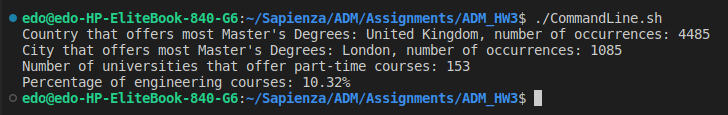

## 7. Algorithmic Question 

### 1. Implement a code to solve the above mentioned problem. 

Let's implement the function that will give us optimal hours for Leonardo. if there is no way to create a report return `None`. 

In [22]:
def optimal_hours(min_max_hours_array, sum_hours):
    sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))

    # If the sum_hours is not in this range, then we can't create a report
    if sum_min_hours <= sum_hours <= sum_max_hours:
        # Each day we work at least min hours
        optimal_hours_array = [x[0] for x in min_max_hours_array]

        # Rest of the hours that we have to add
        temp_sum_hours = sum_hours - sum_min_hours

        for i in range(len(min_max_hours_array)):
            available_hours = min_max_hours_array[i][1] - optimal_hours_array[i]
            additional_hours = min(available_hours, temp_sum_hours)

            optimal_hours_array[i] += additional_hours
            temp_sum_hours -= additional_hours

            # If we managed to reduce hours to 0, there are no hours left to be allocated anymore
            if temp_sum_hours == 0:
                break

        # Checking if the optimal_hours_array report is correct
        if sum(optimal_hours_array) == sum_hours:
            return optimal_hours_array
        else:
            return None
    else:
        return None

Testing the function:

In [23]:
def test_optimal_hours(test_case):
    min_max_hours_array = test_case[0]
    sum_hours = test_case[1]

    optimal_hours_array = optimal_hours(min_max_hours_array, sum_hours)
    if optimal_hours_array:
        print("YES")
        for hours in optimal_hours_array:
            print(hours, end=" ")
    else:
        print("NO")

In [24]:
test_case_1 = [[[0, 1], [3, 5]], 5]
test_case_2 = [[[5, 6]], 1]

In [25]:
test_optimal_hours(test_case_1)

YES
1 4 

In [26]:
test_optimal_hours(test_case_2)

NO


Below is the code that takes the input from console that can be used for testing:

In [17]:
d, sum_hours = map(int, input().split())

min_max_hours_array = []

for _ in range(d):
    min_hours, max_hours = map(int, input().split())
    min_max_hours_array.append([min_hours, max_hours])

test_optimal_hours([min_max_hours_array, sum_hours])

YES
1 4 

Looking at the results, we can see that the input matches the output. 

### 2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

Let's look at the function `optimal_hours(min_max_hours_array, sum_hours)` because it is used for giving us the solution, we will not take the input into consideration:

In [18]:
# sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))

This part of the code is `O(n)`,beacuse we iterate all of the hours once to find the sum of the min and max hours that are needed to work.

In [19]:
# if sum_min_hours <= sum_hours <= sum_max_hours:
#     optimal_hours_array = [x[0] for x in min_max_hours_array]
#     temp_sum_hours = sum_hours - sum_min_hours

# else:
#     return None

Above we have if statement which is `O(1)` and below that we have `O(n)`, because we go through the array once again. Subtraction between sum of hours worked and minimum required is `O(1)`. Else is same as if, `O(1)`.

In [20]:
# for i in range(len(min_max_hours_array)):
#         available_hours = min_max_hours_array[i][1] - optimal_hours_array[i]
#         additional_hours = min(available_hours, temp_sum_hours)

#         optimal_hours_array[i] += additional_hours
#         temp_sum_hours -= additional_hours

#         if temp_sum_hours == 0:
#             break

Now, we have a for loop that goes through each element once; in the worst-case scenario, it is `O(n)` if the solution is not found by the end of the `min_max_hours_array`. All of the calculations inside are `O(1)`, so the final complexity of this for loop is `O(n)`.

In [21]:
# if sum(optimal_hours_array) == sum_hours:
#     return optimal_hours_array
# else:
#     return None

Finally, we look at the optimal hours, `optimal_hours_array` has size the same as `min_max_hours_array`, so finding the sum of all elements is `O(n)`,and if-else statement is `O(1)`.

After analyzing all of the code we get that the final Big-O notation complexity of the code is `O(n)`. 

### 3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). 

The prompt used for asking about the code's time complexity is next:

`can you check the time complexity big o notation of this code: (code of function optimal_hours)`

This is the output:

The provided Python function `optimal_hours` calculates an array of 'optimal hours' based on a given array of minimum and maximum hours for each day and a target sum of hours. Below is the time complexity analysis of the code:

1. **Calculating the sums of minimum and maximum hours:**
   - `sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))`
   This operation runs in `O(n)` time, where `n` is the length of `min_max_hours_array`, since the `sum` and `zip` functions both run in linear time.

2. **Bounds checking for the target sum of hours:**
   - `if sum_min_hours <= sum_hours <= sum_max_hours:`
   This is a constant-time operation, `O(1)`.

3. **Initialization of the optimal hours array:**
   - `optimal_hours_array = [x[0] for x in min_max_hours_array]`
   This list comprehension also runs in `O(n)` time.

4. **Main loop for calculating optimal hours:**
   - `for i in range(len(min_max_hours_array)):`
   The loop itself has a worst-case scenario of `O(n)`.

   Inside the loop, all operations (calculating `available_hours`, `additional_hours`, updating `optimal_hours_array[i]`, and decrementing `temp_sum_hours`) are constant-time operations, `O(1)`.

5. **Final sum check:**
   - `if sum(optimal_hours_array) == sum_hours:`
   This is another `O(n)` operation.

Considering all the above points, the overall time complexity of this function is the sum of the individual complexities. However, since all these operations are sequential and the loop is the most significant portion, the overall time complexity is dominated by the loop and simplifies to `O(n)`. Therefore, the final Big O notation for the function is `O(n)`.

As we can see, and checking with our result, we also got the `O(n)` time complexity for the function `optimal_hours`. We believe it is correct and both calculations are right.

### 4. What do you think of the __optimality__ of your code? Do you believe it is optimal? Can you improve?

Given that the code has a time complexity of `O(n)`, it is quite optimal. However, it can be observed that there are a number of `O(n)` operations being executed, so improvements could be made by combining some for loops. Additionally, the code does not validate the data, which could lead to problems, especially if there are large arrays that are memory-intensive.